In [1]:
from tqdm import tqdm_notebook
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.layers import Dense, Flatten
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import os
import json

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv')
img_size = 128

In [3]:
def resize_to_square(im):
    old_size = im.shape[:2]
    ratio = float(img_size) / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h // 2, delta_h-(delta_h//2)
    left, right = delta_w // 2, delta_w-(delta_w//2)

    color = [0, 0, 0]

    return cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

In [7]:
pet_ids = train_df['PetID'].values

def load_image(path, pet_id):
    image = cv2.imread(f'{path}{pet_id}-1.jpg')
    return resize_to_square(image)

X, Y = [], []
for pet_id in tqdm_notebook(pet_ids):
    try:
        im = load_image("../input/train_images/", pet_id)
        X.append(im)        
        ads = train_df[train_df['PetID'] == pet_id]['AdoptionSpeed'].values[0]
        Y.append(ads)
    except:
        pass

X = np.asarray(X)


CPU times: user 1min 1s, sys: 4.02 s, total: 1min 5s
Wall time: 1min 18s


In [8]:
from sklearn.model_selection import train_test_split
X_tr, X_tst, y_tr, y_tst = train_test_split(X, Y, test_size=0.33, random_state=42)

In [9]:
X_tr = X_tr.astype('float32')
X_tst = X_tst.astype('float32')
X_tr = X_tr / 255
X_tst = X_tst / 255

batch_size = 32
nb_classes = 5
nb_epoch = 50

Y_tr = np_utils.to_categorical(y_tr, nb_classes)
Y_tst = np_utils.to_categorical(y_tst, nb_classes)

# Modelo

In [12]:
model = Sequential()
model.add(Conv2D(img_size, (3, 3), padding='same',
                        input_shape=(img_size, img_size, 3), activation='relu'))
model.add(Conv2D(img_size, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(img_size*2, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(img_size*2, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Treinamento

In [13]:
%%time
history = model.fit(X_tr, Y_tr,
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_split=0.1,
    shuffle=True,
    verbose=2
)

Train on 8834 samples, validate on 982 samples
Epoch 1/50
 - 158s - loss: 1.5106 - acc: 0.2643 - val_loss: 1.4548 - val_acc: 0.2923
Epoch 2/50
 - 145s - loss: 1.4729 - acc: 0.2671 - val_loss: 1.4587 - val_acc: 0.2811
Epoch 3/50
 - 144s - loss: 1.4708 - acc: 0.2692 - val_loss: 1.4631 - val_acc: 0.2902
Epoch 4/50
 - 145s - loss: 1.4718 - acc: 0.2736 - val_loss: 1.4592 - val_acc: 0.2811
Epoch 5/50
 - 144s - loss: 1.4696 - acc: 0.2739 - val_loss: 1.4614 - val_acc: 0.2811
Epoch 6/50
 - 144s - loss: 1.4691 - acc: 0.2756 - val_loss: 1.4601 - val_acc: 0.2923
Epoch 7/50
 - 144s - loss: 1.4693 - acc: 0.2639 - val_loss: 1.4570 - val_acc: 0.2811
Epoch 8/50
 - 144s - loss: 1.4691 - acc: 0.2684 - val_loss: 1.4556 - val_acc: 0.2811
Epoch 9/50
 - 144s - loss: 1.4692 - acc: 0.2760 - val_loss: 1.4555 - val_acc: 0.2923
Epoch 10/50
 - 144s - loss: 1.4657 - acc: 0.2773 - val_loss: 1.4571 - val_acc: 0.2811
Epoch 11/50
 - 144s - loss: 1.4662 - acc: 0.2696 - val_loss: 1.4586 - val_acc: 0.2811
Epoch 12/50
 - 1

# Avaliação

In [14]:
scores = model.evaluate(X_tst, Y_tst, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 26.61%


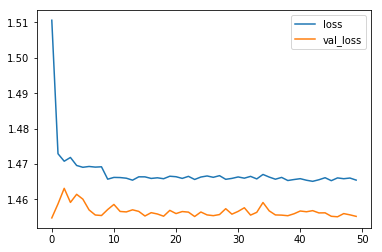

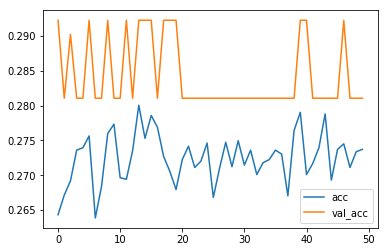

In [15]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

### Prediction and Submission

In [16]:
test_df = pd.read_csv('../input/test/test.csv')
pet_ids_tst = test_df['PetID'].values
sam_sub_df = pd.read_csv('../input/test/sample_submission.csv')
sam_sub_df.head()

(3948, 2)


,PetID,AdoptionSpeed
0,378fcc4fc,0
1,73c10e136,0
2,72000c4c5,0
3,e147a4b9f,0
4,43fbba852,0


In [17]:
sub_dict = {'PetID': [], 'filename': []}

for name in os.listdir('../input/test_images'):
    pet_id = name.split('-')[0]
    sub_dict['PetID'].append(pet_id)
    sub_dict['filename'].append(name)
    
sub_df = pd.DataFrame(sub_dict)
sub_df.head()

,PetID,filename
0,cd5592936,cd5592936-17.jpg
1,712627ad2,712627ad2-4.jpg
2,0079accbd,0079accbd-3.jpg
3,94f6ffdc5,94f6ffdc5-1.jpg
4,ba7974eea,ba7974eea-2.jpg


In [18]:
%%time
test_img = []
pet_id_test_img = []

for pet_id in tqdm_notebook(pet_ids_tst):
    try:
        im = load_image("../input/test_images/", pet_id)
        test_img.append(im)  
        
        pet_id_test_img.append(pet_id)
    except:
        pass 
test_img = np.asarray(test_img)
test_img = test_img.astype('float32')
test_img = test_img / 255


CPU times: user 7.79 s, sys: 1.36 s, total: 9.15 s
Wall time: 12.3 s


In [19]:
%%time
test_predictions = model.predict(test_img)

CPU times: user 2.54 s, sys: 1.54 s, total: 4.08 s
Wall time: 15.2 s


In [20]:
sub_df = pd.DataFrame(test_predictions)
sub_df['PetID'] = pd.Series(pet_id_test_img, index=sub_df.index)
cols = sub_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
sub_df=sub_df[cols]
print(sub_df.shape)
sub_df.head()

(3820, 6)


,PetID,0,1,2,3,4
0,378fcc4fc,0.024261,0.209823,0.278168,0.213825,0.273923
1,73c10e136,0.024261,0.209823,0.278168,0.213825,0.273923
2,72000c4c5,0.024261,0.209823,0.278168,0.213825,0.273923
3,e147a4b9f,0.024261,0.209823,0.278168,0.213825,0.273923
4,43fbba852,0.024261,0.209823,0.278168,0.213825,0.273923
